In [1]:
%matplotlib inline
import numpy as np
from collections import defaultdict
from itertools import permutations
import scipy.sparse.csgraph as csg
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt

def adj_matrix(edge_list):
    N = max(max(edge_list)) 
    
    A = np.zeros((N + 1,N + 1))
    for (i,j) in edge_list:
        A[i,j] = 1
  
    return A + A.T 

def adj_dict(edge_list):
    a_dict = defaultdict(list)
    for (i,j) in edge_list:
        a_dict[i].append(j)
        a_dict[j].append(i)
    return a_dict

def init_obj(z, level_set, d, eta_0):

    phi = sum([d[i,j]*(np.abs(z[i] - z[j]) - d[i,j])**2 for i in level_set for j in level_set if i != j])
    return phi

def objective(z, eta, level_struct, A):
    
    target_set = [i for i in level_struct[eta] + level_struct[eta+1]]
    
    phi = sum([(np.abs(z[i]-z[j]) - 1)**2 for i in level_struct[eta+1] for j in target_set if A[i,j] > 0])
    return phi

def objective_f(z, eta, level_struct, d):
    
    target_set = [i for i in level_struct[eta] + level_struct[eta+1]]

    phi = sum([(np.abs(z[i]-z[j])/d[i,j] - 1)**2 for i in level_struct[eta+1] for j in target_set if i!=j])
    return phi


def permute(z, N, r, indicies):
    i_len = len(indicies)
    for idx in permutations(range(N), i_len):
        zp = z.copy()
        zp[indicies,0] = [r * np.exp(w*2*np.pi*np.complex(0,1)/N) for w in idx]
        yield zp
    
def initialise(z, eta_0, level_set, d):

    if len(level_set) == 1:
        return z, 0, 0
    elif len(level_set) < 4:
        R_0 = 0.5
    else:
        R_0 = 1
    
    N_0 = int(2*np.ceil(len(level_set)/2))
    f = lambda x: init_obj(x, level_set, d, eta_0)

    for zp in permute(z, N_0, R_0, level_set):
        phi = f(zp)
        try:
            if phi_min > phi:
                phi_min = phi
                z_min = zp
        except NameError:
            z_min = zp
            phi_min = phi

    return z_min, R_0, N_0
    

def optimise_layer(z, N_eta, R, eta, level_struct, adj, D):
    
    N = int(max(N_eta, 2*np.ceil(len(level_struct[eta+1])/2)))
    
    #f = lambda x: objective(x, eta, level_struct, adj)
    f = lambda x: objective_f(x, eta, level_struct, D)
    z_min = z
    for zp in permute(z, N, R, level_struct[eta+1]):
        phi = f(zp)
        try:
            if phi_min > phi:
                z_min = zp
                phi_min =phi
        except NameError:
            z_min = zp
            phi_min = phi
    
    return z_min, N

def plot(z, edge_list):
    fig = plt.figure(figsize=(10,10))
    R = 0 if min(abs(z)) < 0.00001 else -0.5
    theta = np.linspace(0, 2*np.pi, 100)
    axes = fig.gca()
    axes.set_aspect('equal')
    rad = 0.1

    while R < max(abs(z)):
        R+=1
        axes.plot(R*np.cos(theta), R*np.sin(theta), color='grey', linestyle=':', linewidth=0.5)

    points = [(zp.real, zp.imag) for zp in z.flatten()]
    for i, j in edge_list:
        x1, y1 = points[i]
        x2, y2 = points[j] 
        axes.plot([x1,x2],[y1,y2], color='k')

    for k, (x,y) in enumerate(points):
        axes.text(x,y, str(k), ha="center", va="center", transform=axes.transData,
                 bbox =dict(boxstyle='circle', fc="w", ec="k"))
    
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
    return fig

def arrange_graph(edge_list):
    A = adj_matrix(edge_list)
    n, _ = A.shape
    D = csg.floyd_warshall(A, directed=False)
    ecen = D.max(1)
    eta_0 = int(ecen.min())
    level_struct = {int(eta): np.where(ecen == eta)[0].tolist() for eta in np.unique(ecen)}
    z = np.zeros((n,1), dtype=np.complex_)
    z, R, N = initialise(z, eta_0, level_struct[eta_0], D)

    for k, eta in enumerate(range(eta_0, max(level_struct.keys()))):
        R += 1
        z, N = optimise_layer(z, N, R, eta, level_struct, A, D)
        
    return plot(z, edge_list)

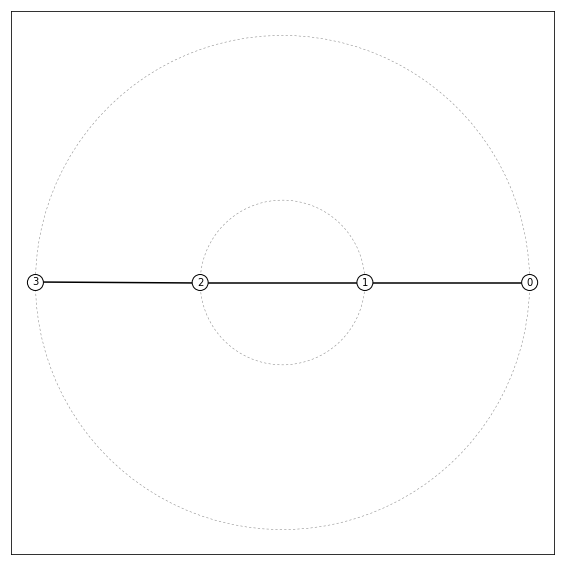

In [2]:
#Graph 1
graph_1 = [(0,1),(1,2),(2,3)]
fig = arrange_graph(graph_1)

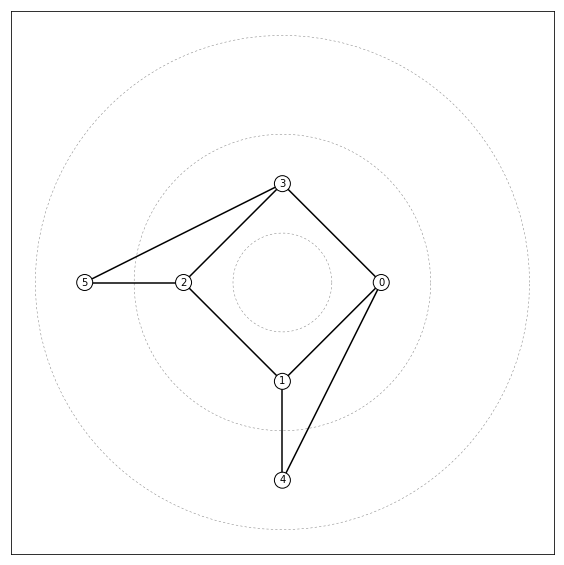

In [3]:
graph_2 = [(0,1),(1,2),(2,3),(0,3),(0,4),(1,4),(2,5),(3,5)]
fig = arrange_graph(graph_2)

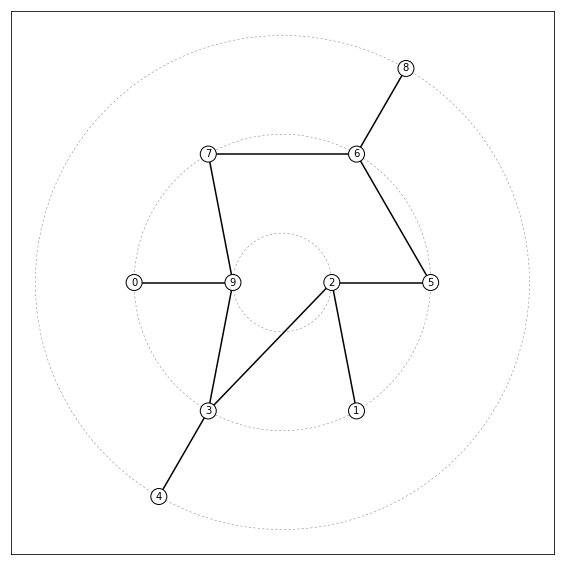

In [4]:
graph_3 = [(1,2), (2,3),(3,4),(2,5),(5,6),(6,7),(6,8),(7,9),(9,0),(3,9)] 
fig = arrange_graph(graph_3)

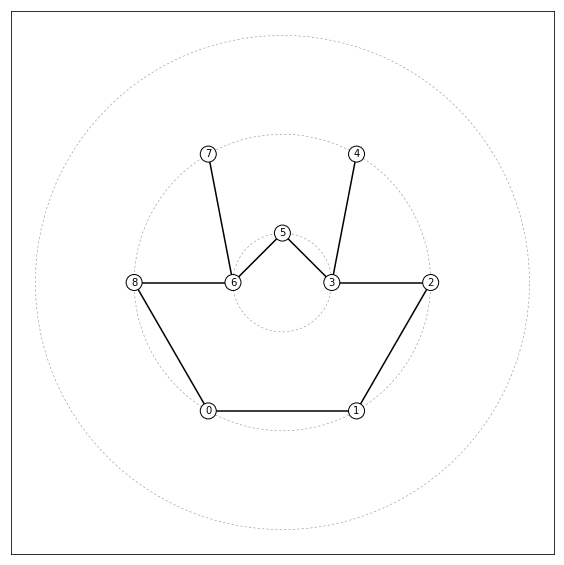

In [5]:
graph_4 = [(0,1),(1,2),(2,3),(3,4),(3,5),(5,6),(6,7),(6,8),(0,8)]
fig = arrange_graph(graph_4)

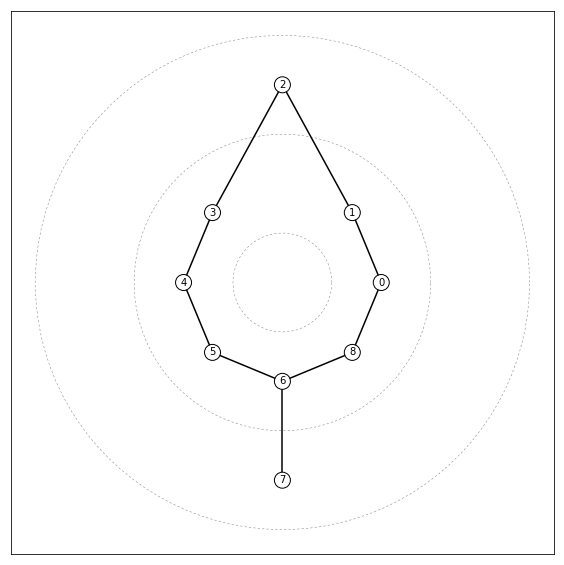

In [6]:
graph_5 = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(6,8),(0,8)]
fig = arrange_graph(graph_5)

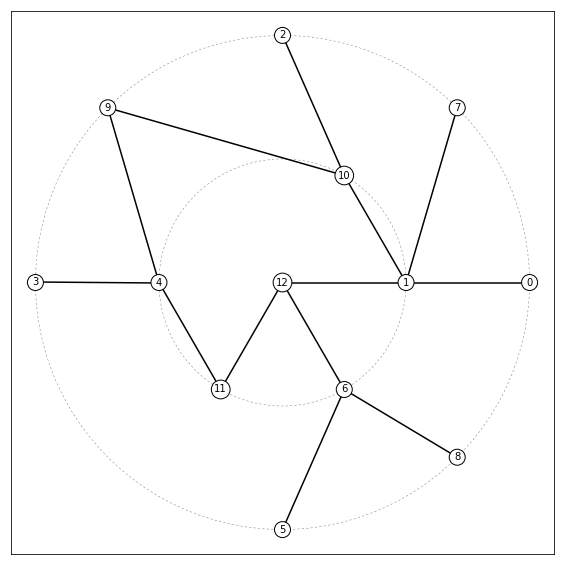

In [7]:
graph_6 =  [(1,0),(4,3),(6,5),(7,1),(8,6),(10,9),(1,10),(2,10),(9,4),(12,11),(4,11),(12,1),(12,6)]
fig = arrange_graph(graph_6)